<a href="https://colab.research.google.com/github/Nandine0804/Age-Calculator-in-days/blob/main/Medical_Image_Generation_Using_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Image Generation Using Diffusion Model**

## **Important Libraries**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 255.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 253.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 161.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 245.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 263.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 160.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 265.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 283.7 MB/s eta 0:00:00
  Preparing metadata (setup.py

In [ ]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from medmnist.dataset import MedMNIST
from medmnist.info import INFO
from medmnist.utils import montage2d

import os
import cv2
import random
import math

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
MAX_EPOCH = 100
BATCH_SIZE = 200
LR = 4.3e-02
CHECKPOINT_DIR = os.getcwd()
FLAG = "bloodmnist"
IMAGE_SIZE = 32
N_CHANNEL = INFO[FLAG]['n_channels']

## **Dataset**

### **Configuration**

In [ ]:
DATA_SEED = int(np.random.randint(2147483647))
print(f"Random seed: {DATA_SEED}")

Random seed: 871242078


### **Utils**

In [ ]:
image_transform = Compose(
    [
        Resize(IMAGE_SIZE),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [ ]:
class MedMNIST2D(MedMNIST):
    @property
    def __prune__(self):
        random.seed(DATA_SEED)
        random.shuffle(self.imgs)
        prune_idx = len(self.imgs) - (len(self.imgs) % BATCH_SIZE)
        if self.split == "train":
            self.imgs = self.imgs[:prune_idx]
        elif self.split == "test":
            self.imgs = self.imgs[:prune_idx]
        elif self.split == "val":
            self.imgs = self.imgs[:prune_idx]
        else:
            raise ValueError

    def __getitem__(self, index):
        """
        return: (without transform/target_transofrm)
            img: PIL.Image
        """
        img = self.imgs[index]
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img

    def montage(self, length=20, replace=False, save_folder=None):
        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(
            imgs=self.imgs, n_channels=self.info["n_channels"], sel=sel
        )

        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(
                os.path.join(save_folder, f"{self.flag}_{self.split}_montage.jpg")
            )

        return montage_img


class BiomedicalDataset(MedMNIST2D):
    flag = FLAG

In [ ]:
TrainDataset = BiomedicalDataset(
    split="train",
    transform=image_transform,
    download=True,
)
TestDataset = BiomedicalDataset(
    split="test",
    transform=image_transform,
    download=True,
)
ValDataset = BiomedicalDataset(
    split="val",
    transform=image_transform,
)

100%|██████████| 35461855/35461855 [00:06<00:00, 5656003.44it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
TrainDataset.__prune__
TestDataset.__prune__
ValDataset.__prune__

### **Description**

In [ ]:
INFO[FLAG]['description']

'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.'

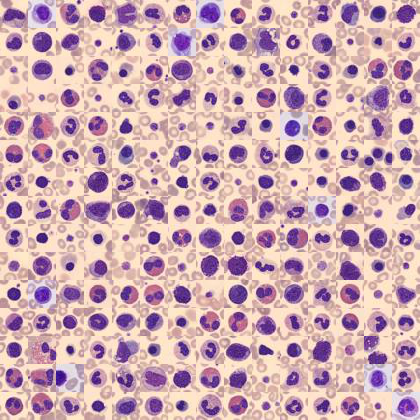

In [ ]:
TrainDataset.montage(15)

## **Model**

### **Utils**

In [ ]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.scores[np.maximum(len(self.scores)-self.num, 0):]
            )
        )
        return out

### **Noise Scheduler**

In [ ]:
class NoiseScheduler(nn.Module):
    def __init__(self, T=500):
        super().__init__()

        self.T = T

        self.betas = torch.linspace(1e-04, 2e-02, self.T)
        alphas = 1.0 - self.betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        self.posterior_variance = (
            self.betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )

    def forward(self, x, t):
        return self._forward_diffusion_sample(x, t)

    def _forward_diffusion_sample(self, x_0, t):
        """
        Takes an image and a timestep as input and
        returns the noisy version of it
        """
        device = "cpu" if not torch.cuda.is_available() else "cuda"
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = get_index_from_list(
            self.sqrt_alphas_cumprod, t, x_0.shape
        )
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(device) * x_0.to(
            device
        ) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(
            device
        )

In [ ]:
FORWARD = NoiseScheduler

### **U-Net**

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(
        self,
        x,
        t,
    ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class UNet(nn.Module):
    def __init__(self, image_channels=N_CHANNEL, scale=4):
        super().__init__()

        down_channels = (
            64 // scale,
            128 // scale,
            256 // scale,
            512 // scale,
            1024 // scale,
        )
        up_channels = (
            1024 // scale,
            512 // scale,
            256 // scale,
            128 // scale,
            64 // scale,
        )
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            PositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()

            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [ ]:
BACKWARD = UNet

### **Wrapper**

In [ ]:
class DiffusionModel(L.LightningModule):
    def __init__(
        self,
        forward_model,
        backward_model,
        batch_size,
        lr,
        max_epoch,
    ):
        super().__init__()

        self.forward_model = forward_model
        self.backward_model = backward_model

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.automatic_optimization = False

        self.model_loss = []
        self.val_fid = []
        self.val_mean_kid = []
        self.val_std_kid = []

        self.model_loss_recorder = AvgMeter()
        self.val_fid_recorder = AvgMeter()
        self.val_mean_kid_recorder = AvgMeter()
        self.val_std_kid_recorder = AvgMeter()

        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._T = self.forward_model.T

        self.fid = FrechetInceptionDistance(feature=64, normalize=True)
        self.kid = KernelInceptionDistance(
            feature=64,
            subset_size=50,
            normalize=True,
        )

    def forward(self, x, t):
        if self.training:
            x_noisy, noise = self.forward_model(x, t)
            noise_pred = self.backward_model(x_noisy, t)
            return F.l1_loss(noise, noise_pred)
        else:
            return self.backward_model(x, t)

    def on_train_epoch_start(self):
        self.fid.reset()
        self.kid.reset()

    def training_step(self, batch, batch_nb):
        x = batch
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)
        t = torch.randint(0, self._T, (self.batch_size,), device=self._device).long()
        loss = self(x, t)
        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()
        self.log("model_loss", loss, prog_bar=True)
        self.model_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.model_loss.append(self.model_loss_recorder.show().data.cpu().numpy())
        self.model_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x = batch
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)

        _x = torch.randn(x.shape, device=self._device)
        for _t in range(0, self._T)[::-1]:
            t = torch.full((x.shape[0],), _t, device=self._device, dtype=torch.long)
            betas_t = get_index_from_list(self.forward_model.betas, t, _x.shape)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
                self.forward_model.sqrt_one_minus_alphas_cumprod, t, _x.shape
            )
            sqrt_recip_alphas_t = get_index_from_list(
                self.forward_model.sqrt_recip_alphas, t, _x.shape
            )
            model_mean = sqrt_recip_alphas_t * (
                _x - betas_t * self(_x, t) / sqrt_one_minus_alphas_cumprod_t
            )
            posterior_variance_t = get_index_from_list(
                self.forward_model.posterior_variance, t, _x.shape
            )
            if torch.sum(t) == 0:
                _x = model_mean
            else:
                noise = torch.randn_like(_x)
                _x = model_mean + torch.sqrt(posterior_variance_t) * noise.to(
                    self._device
                )
            _x = torch.clamp(_x, -1.0, 1.0)

        self.fid.update((_x + 1.0) / 2.0, real=False)
        self.kid.update((_x + 1.0) / 2.0, real=False)

        fid = self.fid.compute().data.cpu()
        self.log("val_fid", fid, prog_bar=True)
        self.val_fid_recorder.update(fid)

        mu_kid, std_kid = self.kid.compute()
        self.log("val_mean_kid", mu_kid.data.cpu(), prog_bar=True)
        self.log("val_std_kid", std_kid.data.cpu(), prog_bar=True)
        self.val_mean_kid_recorder.update(mu_kid.data.cpu())
        self.val_std_kid_recorder.update(std_kid.data.cpu())

    def on_validation_epoch_end(self):
        self.val_fid.append(self.val_fid_recorder.show().data.cpu().numpy())
        self.val_fid_recorder = AvgMeter()

        self.val_mean_kid.append(self.val_mean_kid_recorder.show().data.cpu().numpy())
        self.val_mean_kid_recorder = AvgMeter()

        self.val_std_kid.append(self.val_std_kid_recorder.show().data.cpu().numpy())
        self.val_std_kid_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x = batch
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)

        _x = torch.randn(x.shape, device=self._device)
        for _t in range(0, self._T)[::-1]:
            t = torch.full((x.shape[0],), _t, device=self._device, dtype=torch.long)
            betas_t = get_index_from_list(self.forward_model.betas, t, _x.shape)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
                self.forward_model.sqrt_one_minus_alphas_cumprod, t, _x.shape
            )
            sqrt_recip_alphas_t = get_index_from_list(
                self.forward_model.sqrt_recip_alphas, t, _x.shape
            )
            model_mean = sqrt_recip_alphas_t * (
                _x - betas_t * self(_x, t) / sqrt_one_minus_alphas_cumprod_t
            )
            posterior_variance_t = get_index_from_list(
                self.forward_model.posterior_variance, t, _x.shape
            )
            if torch.sum(t) == 0:
                _x = model_mean
            else:
                noise = torch.randn_like(_x)
                _x = model_mean + torch.sqrt(posterior_variance_t) * noise.to(
                    self._device
                )
            _x = torch.clamp(_x, -1.0, 1.0)
        self.fid.update((_x + 1.0) / 2.0, real=False)
        self.kid.update((_x + 1.0) / 2.0, real=False)

    def on_test_epoch_end(self):
        fid = self.fid.compute().data.cpu()
        self.log("test_fid", fid, prog_bar=False, logger=True)

        mu_kid, std_kid = self.kid.compute()
        self.log("mu_kid", mu_kid.data.cpu(), prog_bar=False, logger=True)
        self.log("std_kid", std_kid.data.cpu(), prog_bar=False, logger=True)

    def on_train_end(self):
        # Loss
        loss_img_file = f"/content/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.model_loss, color="r")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Evaluation Metrics
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_fid_plot.png"
        plt.plot(self.val_fid[1:], color="b")
        plt.title("FID Curves")
        plt.xlabel("Epoch")
        plt.ylabel("FID")
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

        evaluation_metric_img_file = f"/content/{MODEL_NAME}_kid_plot.png"
        self.val_mean_kid = np.array(self.val_mean_kid)[1:]
        self.val_std_kid = np.array(self.val_std_kid)[1:]
        epochs = list(range(self.max_epoch))
        fig, ax = plt.subplots()
        ax.plot(epochs, self.val_mean_kid)
        ax.fill_between(
            epochs,
            self.val_mean_kid - self.val_std_kid,
            self.val_mean_kid + self.val_std_kid,
            alpha=0.3,
        )
        ax.set_title("KID Curves")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("KID")
        ax.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-4,
            momentum=0.9,
            nesterov=True,
        )

        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.max_epoch * 0.01),
                int(self.max_epoch * 0.12),
                int(self.max_epoch * 0.23),
                int(self.max_epoch * 0.34),
                int(self.max_epoch * 0.45),
                int(self.max_epoch * 0.56),
                int(self.max_epoch * 0.67),
                int(self.max_epoch * 0.78),
                int(self.max_epoch * 0.89),
                int(self.max_epoch * 0.90),
            ],
            gamma=(
                ((1.0 + math.sqrt(5)) / 2.0)
                - (1.0 / math.pi + 1.0 / math.e + 1.0 / math.tau)
            )
            / math.sqrt(2),
        )

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = DiffusionModel.__name__

## **Training**

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1345331842


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

INFO: Global seed set to 1345331842
INFO:lightning.fabric.utilities.seed:Global seed set to 1345331842
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 41.7MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


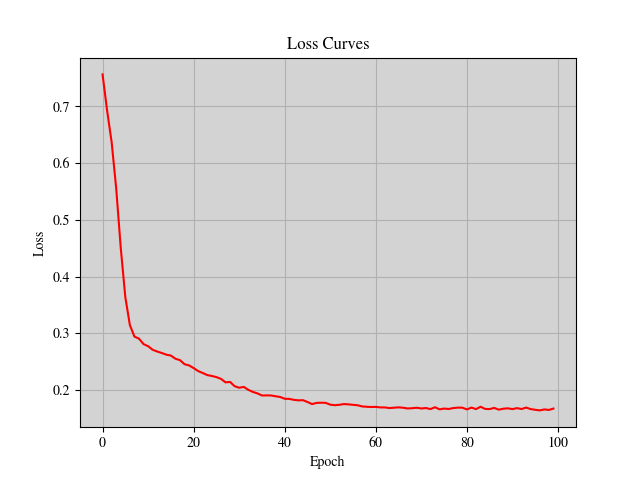

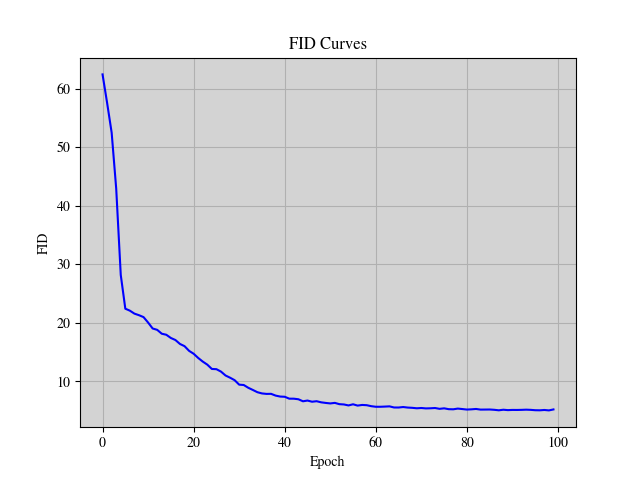

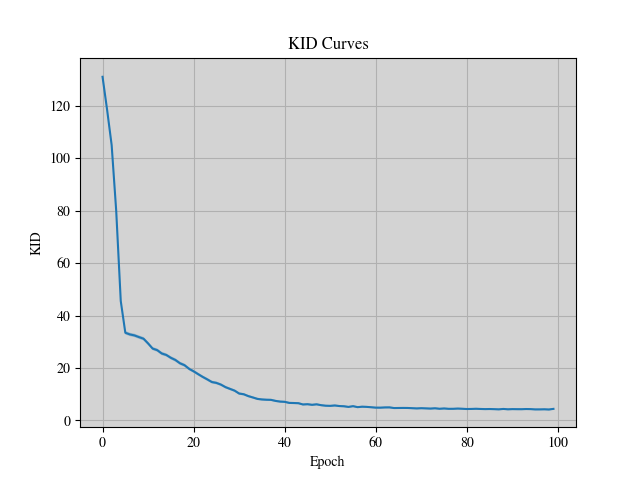

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
seed_everything(SEED, workers=True)

model = DiffusionModel(FORWARD(), BACKWARD(), BATCH_SIZE, LR, MAX_EPOCH)

tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
checkpoint = ModelCheckpoint(
    monitor='val_fid',
    dirpath=CHECKPOINT_DIR,
    mode='min',
)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[checkpoint],
    log_every_n_steps=5,
)
trainer.fit(model)

## **Testing**

In [ ]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

In [ ]:
trainer.test(ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"))

INFO: Restoring states from the checkpoint path at /content/DiffusionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/DiffusionModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/DiffusionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/DiffusionModel_best.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          mu_kid           │     4.140571117401123     │
│          std_kid          │    0.3429620862007141     │
│         test_fid          │     5.038834571838379     │
└───────────────────────────┴───────────────────────────┘

[{'test_fid': 5.038834571838379,
  'mu_kid': 4.140571117401123,
  'std_kid': 0.3429620862007141}]

## **Inference**

### **Utils**

In [ ]:
def show_tensor_image(image):
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.numpy().astype(np.uint8)),
        ToPILImage(),
        Resize(IMAGE_SIZE),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    plt.axis('off')
    plt.imshow(reverse_transforms(image))

In [ ]:
DEVICE = "cpu" if not torch.cuda.is_available() else 'cuda'

In [ ]:
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    map_location=DEVICE,
    forward_model=FORWARD(),
    backward_model=BACKWARD(),
    batch_size=BATCH_SIZE,
    lr=LR,
    max_epoch=MAX_EPOCH,
)
model.eval()

In [ ]:
T = 500
betas = torch.linspace(1e-04, 2e-02, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [ ]:
num_images = 5
stepsize = int(T/num_images)

### **Visualize**

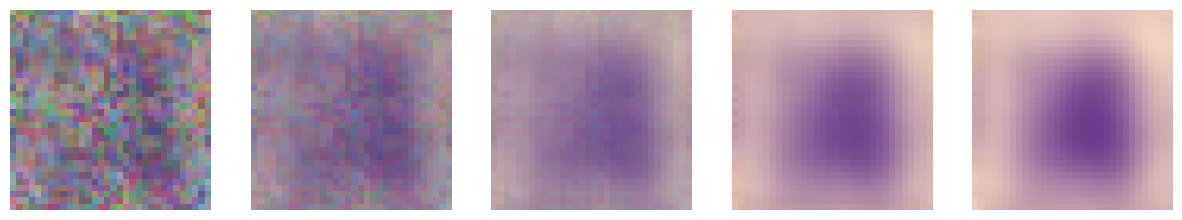

<Figure size 640x480 with 0 Axes>

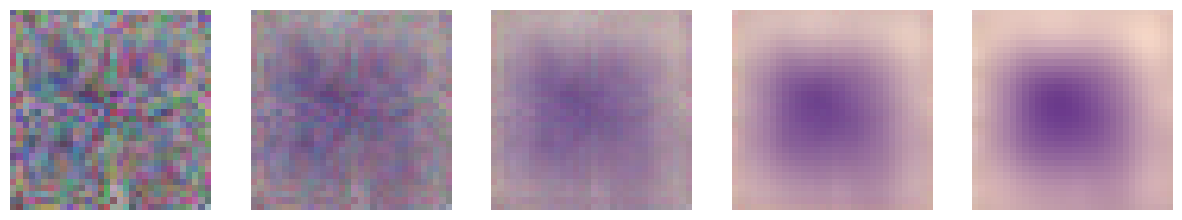

<Figure size 640x480 with 0 Axes>

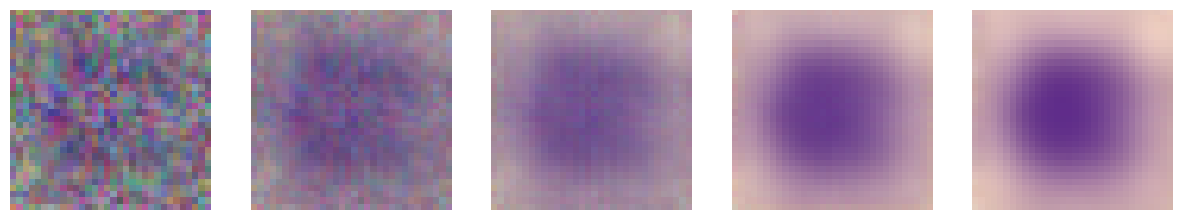

<Figure size 640x480 with 0 Axes>

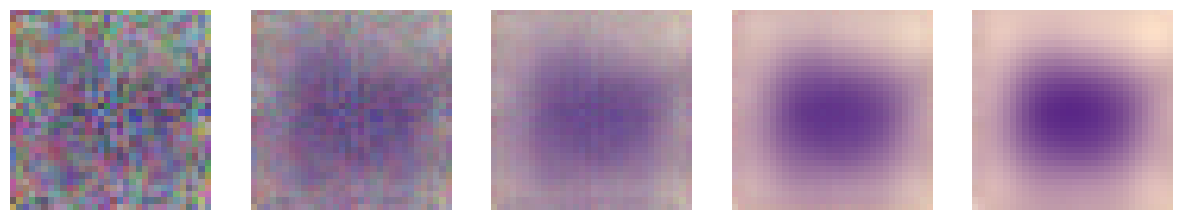

<Figure size 640x480 with 0 Axes>

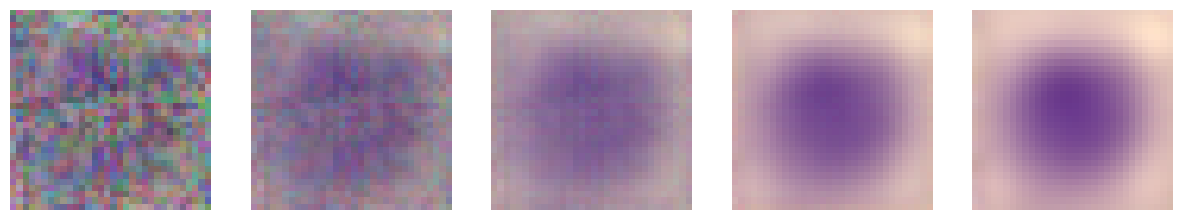

<Figure size 640x480 with 0 Axes>

In [ ]:
for _ in range(5):
    plt.figure(figsize=(15, 15))
    _x = torch.randn((1, N_CHANNEL, IMAGE_SIZE, IMAGE_SIZE), device=DEVICE)
    for _t in range(0, T)[::-1]:
        t = torch.full((1,), _t, device=DEVICE, dtype=torch.long)
        betas_t = get_index_from_list(betas, t, _x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
            sqrt_one_minus_alphas_cumprod, t, _x.shape
        )
        sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, _x.shape)
        model_mean = sqrt_recip_alphas_t * (
            _x - betas_t * model(_x, t) / sqrt_one_minus_alphas_cumprod_t
        )
        _x = model_mean
        _x = torch.clamp(_x, -1.0, 1.0)
        if _t % stepsize == 0:
            plt.subplot(
                1,
                num_images,
                ((num_images + 1) - min(num_images, int(_t / stepsize) + 1)),
            )
            show_tensor_image(_x[:,:,1:-1,1:-1].detach().cpu())
    plt.show()
    plt.clf()